# **Sudoku Game with Deep Learning, OpenCV and Backtracking**

The sudoku game is something almost everyone plays either on a daily basis or at least once in a while. The game consists of a 9×9 board with numbers and blanks on it. The goal is to fill the blank spaces with suitable numbers. These numbers can be filled keeping in mind some rules. The rule for filling these empty spaces is that the number should not appear in the same row, same column or in the same 3×3 grid. Wouldn’t it be interesting to use the concepts of OpenCV, deep learning and backtracking to solve a game of sudoku?

In this practice session, we will build an automatic sudoku solver using deep learning, OpenCV image processing and backtracking. 

## **Using CNN and MNIST dataset**

Now, since this game involves numbers let us make use of the simple MNIST dataset and build a neural network on it. We will use Keras to build this neural network.

## **Import libraries and load the data**

In [ ]:
!python -m pip install pip --upgrade --user -q --no-warn-script-location
!python -m pip install numpy pandas seaborn matplotlib scipy statsmodels sklearn nltk gensim keras tensorflow pillow scikit-image opencv-python --user -q --no-warn-script-location

import IPython
IPython.Application.instance().kernel.do_shutdown(True)


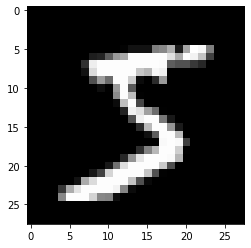

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Lambda, MaxPooling2D, Flatten, Dense,Conv2D
from keras.utils.np_utils import to_categorical
from keras.datasets import mnist
(trainx,trainy),(testx,testy)=mnist.load_data()
import matplotlib.pyplot as plt
plt.imshow(trainx[0], cmap=plt.get_cmap('gray'))
plt.show()

## **Data pre-processing**

Let us pre-process the data by reshaping them and normalizing the data. I have also converted the target column into categorical values.

In [2]:
trainx = trainx.reshape(60000, 28, 28, 1)
testx = testx.reshape(10000, 28, 28, 1)
trainx=trainx/255
testx = testx / 255
trainy= to_categorical(trainy)
testy = to_categorical(testy)
num_classes=testy.shape[1]

## **Build a sequential CNN and train**

Here we will build a convolutional neural network with only three layers since we are using MNIST data and it is easy to converge. 

In [3]:
model = Sequential()
model.add(Convolution2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(Convolution2D(64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(trainx,trainy, validation_data=(testx, testy), epochs=3)

Epoch 1/3
1875/1875 [==============================] - 248s 131ms/step - loss: 0.1220 - accuracy: 0.9637 - val_loss: 0.0497 - val_accuracy: 0.9837
Epoch 2/3
1875/1875 [==============================] - 212s 113ms/step - loss: 0.0440 - accuracy: 0.9859 - val_loss: 0.0394 - val_accuracy: 0.9875
Epoch 3/3
1875/1875 [==============================] - 172s 92ms/step - loss: 0.0279 - accuracy: 0.9913 - val_loss: 0.0461 - val_accuracy: 0.9866


Now that the model has been trained, we can save the weights of the model and use it for the sudoku game. 

In [4]:
# model.save('sudokucnn.h5')

## **Using OpenCV for image processing**

After we have built the model and saved it, let us now move on to the image processing part of the puzzle. For this, I have selected a random puzzle from the internet. 


In [ ]:
# !wget https://riyadmahmud111.files.wordpress.com/2013/03/easypuzzle.png

You can download the above image with this link. Once you have this image, let us use OpenCV and read this image. 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
puzzle= cv2.imread('easypuzzle.png')
gray_puzzle= cv2.cvtColor(puzzle, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray_puzzle,cmap='gray')

The next step here is to reduce the background noise in the image and set all the blanks to 0 value since the machine needs to understand where the numbers have to be filled. 

To do this, we will use the OpenCV gaussian blur and the inverse binary threshold. Using the inverse binary threshold, the destination pixels will be set to zero if the condition that the source pixel is greater than zero is satisfied. 

In [ ]:
destination = cv2.GaussianBlur(gray_puzzle,(1,1),cv2.BORDER_DEFAULT)
source_px,threshold_val = cv2.threshold(gray_puzzle, 180, 255,cv2.THRESH_BINARY_INV)
plt.imshow(threshold_val,cmap='gray')

As the image shows, all the destination pixels have been converted to grayscale. 

Now, we have the source and destination pixels but the image grids are not being read. This is important because the machine needs to understand that there are 9 3X3 grids present within the main grid. To do this, we will use the probabilistic hough transform and warping methods of Opencv.

In [ ]:
grid = cv2.HoughgridP(threshold_val,1,np.pi/180,100,set_min=100,set_max=10)
for lines in grid:
    hor_1,ver_1,hor_2,ver_2 = lines[0]
    cv2.line(image,(hor_1,ver_1),(hor_2,ver_2),(0,255,0),2, cv2.LINE_AA)
cv2.imwrite('tranform.jpg',image)
hough_image = cv2.imread('transform.jpg',0)
final = cv2.imread('transform.jpg')
plt.imshow(final, cmap='gray')

The final step of image processing is to warp the image so that the complete top-down view can be obtained. This is an important step so that the machine understands how to read the image and where it should start reading the image from.

To do this, we need to contour the image and then find the width and height of the image as follows.

In [ ]:
cont,value = cv2.findContours(hough_img,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
area = cont[0]
max_area = cv2.contourArea(area)
for cont in cont:
    if cv2.contourArea(cont) > max_area:
        area = cont
        max_area = cv2.contourArea(cont)
eps = 0.01*cv2.arcLength(area,True)
final_cont = cv2.approxPolyDP(area, eps, True)
def take_point(point):
    grid_rect = np.zeros((4, 2), dtype = "float32")
    summation = point.sum(axis = 1)
    grid_rect[0] = point[0]
    grid_rect[2] = point[2]
    diff = np.diff(point, axis = 1)
    grid_rect[3] = point[3]
    grid_rect[1] = point[1]
    return grid_rect
def warping(image, point):
    grid_rect = take_point(point)
    (len1, len2, breadth1, breadth2) = grid_rect
    width_1 = np.sqrt(((breadth1[0] - breadth2[0]) ** 2) + ((breadth1[1] - breadth2[1]) ** 2))
    width_2 = np.sqrt(((len2[0] - len1[0]) ** 2) + ((len2[1] - len1[1]) ** 2))
    tot_width = max(int(width_1), int(width_2))
    height_1 = np.sqrt(((len2[0] - breadth1[0]) ** 2) + ((len2[1] - breadth1[1]) ** 2))
    height_2 = np.sqrt(((len1[0] - breadth2[0]) ** 2) + ((len1[1] - breadth2[1]) ** 2))
    tot_height = max(int(height_1), int(height_2))
    destination = np.array([
        [0, 0],
        [0, tot_height - 1],
        [tot_width - 1, tot_height - 1],
        [tot_width - 1, 0]], dtype = "float32")
    M = cv2.getPerspectivelen2ansform(grid_rect, destination)
    warped = cv2.warpPerspective(image, M, (tot_width, tot_height))
    return warped

Once the image is warped we can save this and move on to the predictions. 

In [ ]:
warped_img = wapring(threshold_val,final_cont)


## **Making predictions**

Once we have the image and model ready, we can start loading them and making the predictions on the image. 

In [ ]:
sudoku_model= load_model('sudokucnn.h5')

Now, the first step is to write a function that will predict all the existing numbers on the grid. 

In [ ]:
def existining_pred(output_img):
    classes = sudokumodel.predict_classes(output_img)
    if classes == [[0]]:
        return 0
    elif classes == [[1]]:
        return 1
    elif classes == [[2]]:
        return 2
    elif classes == [[3]]:
        return 3
    elif classes == [[4]]:
        return 4
    elif classes == [[5]]:
        return 5
    elif classes == [[6]]:
        return 6
    elif classes == [[7]]:
        return 7
    elif classes == [[8]]:
        return 8
    elif classes == [[9]]:
        return 9

Next, we need to extract the positions of the individual cells. This can be done as follows:

In [ ]:
def getcells(warped_img):
    warped_img = cv2.resize(img,(252,252))
    cells = []
    wt = warped_img.shape[1]
    ht = warped_img.shape[0]
    cell_wt = wt//9
    cell_height = ht//9
    hor_1,hor_2,ver_1,ver_2 = 0,0,0,0
    for i in range(9):
        ver_2 = ver_1 + cell_height
        hor_1 = 0
        for j in range(9):
            hor_2 = hor_1 + cell_wt
            current_cell = [hor_1,hor_2,ver_1,ver_2]
            cells.append(current_cell)
            hor_1 = hor_2
        ver_1 = ver_2
    return cells  

Now, we will predict the numbers by writing the logic to understand the rules of the game as shown below. 

In [ ]:
def predictnums(cell,img):
    position = []
    img = cv2.resize(img,(252,252))
    img = img[cell[2]+2:cell[3]-3,cell[0]+2:cell[1]-3]
    cont,value = cv2.findContours(img.copy(), cv2.RElen2_len2EE, cv2.CHAIN_APPROX_SIMPLE)
    if len(cont) != 0:
        for c in cont:
            x,y,w,h = cv2.boundinggrid_rect(c)
            if (w < 15 and x > 2) and (h < 25 and y > 2):
                position.append((x,y,x+w,y+h))
                break
    if position == []:
        result = 0
    if position:
        img1 = img[(position[0][1]):(position[0][3]),(position[0][0]):(position[0][2])]
        img1 = cv2.resize(img,(28,28))
        img1 = img1.reshape(1,28,28,1)
        result = existining_pred(img1)
    return result

Now, we will use the transformed image that was created earlier and extract the sudoku digits and print the board as per the extracted values. 

In [ ]:
def sudoku_dig(warped_img):
    cell_digits,num = [],0
    cells = getcells(warped_img)
    for cell in range(len(cells)):
        num = predictnums(cells[cell],warped_img)
        cell_digits.append(num)
    n = 9
    cell_digits = [cell_digits[i:i+n] for i in range(0, len(cell_digits), n)] 
    return cell_digits
puzzle = sudoku_dig(warped_img)
def get_board(board_img):
    for i in range(len(board_img)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")
        for j in range(len(board_img[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")
            if j == 8:
                print(board_img[i][j])
            else:
                print(str(board_img[i][j]) + " ", end="")
get_board(puzzle)

## **Backtracking for making predictions**

For solving this format of the board, we need to first let the machine find empty spaces and check for the valid numbers that can be put in the right spaces. Empty spaces are those that have 0 as the value. 

In [ ]:
def check_empty(board_img):
    for i in range(len(board_img)):
        for j in range(len(board_img[0])):
            if board_img[i][j] == 0:
                return (i, j)
    return None

After identification of this, let us now use backtracking to solve the sudoku puzzle. Backtracking is basically a recusrive algorithm that tests all possible paths that can be taken to give the best possible solution. 

In [ ]:
def backtrack(board_img, digits, position):
    for i in range(len(board_img[0])):
        if board_img[position[0]][i] == digits and position[1] != i:
            return False
    for i in range(len(board_img)):
        if board_img[i][position[1]] == digits and position[0] != i:
            return False
    board_img_x = position[1] // 3
    board_img_y = position[0] // 3
    for i in range(board_img_y*3, board_img_y*3 + 3):
        for j in range(board_img_x * 3, board_img_x*3 + 3):
            if board_img[i][j] == digits and (i,j) != position:
                return False
def get_solution(board_img):
    check = check_empty(board_img)
    if not check:
        return True
    else:
        x, y = check
    for i in range(1,10):
        if backtrack(board_img, i, (x, y)):
            board_img[x][y] = i
            if get_solution(board_img):
                return True
            board_img[x][y] = 0
    return False
get_solution(puzzle)
print_board(puzzle)

As you can see above, the final solution has the numbers in the grid that were obtained with backtracking. 

#**Related Articles:**

> * [Sudoku Game with Deep Learning, OpenCV and Backtracking](https://analyticsindiamag.com/solve-sudoku-puzzle-using-deep-learning-opencv-and-backtracking/)

> * [Finding Waldo Game with OpenCV](https://analyticsindiamag.com/my-fun-project-with-opencv-finding-waldo-game/)

> * [OpenCV to Extract Information From Table Images](https://analyticsindiamag.com/how-to-use-opencv-to-extract-information-from-table-images/)

> * [Credit Card Reader](https://analyticsindiamag.com/how-i-created-the-credit-card-reader-using-opencv/)

> * [Real Time GUI Interactions with OpenCV](https://analyticsindiamag.com/real-time-gui-interactions-with-opencv-in-python/)

